In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 1. Feature Preperation for X-Grad Boost

In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final.csv'
df = pd.read_csv(file_path)

In [3]:
df.to_csv('/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Utilitarian_Final.csv', index=False)

In [4]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful
df['helpful'] = (df['helpful_ratio'] > 0).astype(int)

In [5]:
# Define features and target variable
features = ['Rating','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
            'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE', 'Prod']
target = 'helpful'

In [6]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Define categorical and numerical features
categorical_features = ['Prod']
numerical_features = ['Rating','Sentiment','Subjective', 'WordC', 'SentC', 'SentL', 'TitleL', 'ElapDays',
            'Image', 'VerPur', 'NounR', 'AdjR', 'AdvR', 'FRE']

# Convert 'product' column to categorical type
df['Prod'] = df['Prod'].astype('category')

# Prepare  X and y
X = df[features]
y = df[target]

# Initialize ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),  # One-hot encode 'product'
        ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Retrieve column names for the one-hot encoded features
cat_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine column names for the transformed features
all_column_names = np.concatenate([cat_column_names, numerical_features])

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=all_column_names)

# 1. Basic X-Grad Boost Model

In [7]:
# Split data for test and training data
X_train, X_test, y_train, y_test = train_test_split(
    df[features],  
    df[target], 
    test_size=0.2,  
    random_state=42  # Set a random seed for reproducibility
)

In [8]:
from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['Prod'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=4)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print the shapes of the resulting splits to check
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Optionally, you can check the distribution in each split
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (13725, 18)
X_test shape: (4576, 18)
y_train shape: (13725,)
y_test shape: (4576,)
Train stratify distribution:
 helpful
0    0.839563
1    0.160437
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.839161
1    0.160839
Name: proportion, dtype: float64
X_train shape: (13726, 18)
X_test shape: (4575, 18)
y_train shape: (13726,)
y_test shape: (4575,)
Train stratify distribution:
 helpful
0    0.839502
1    0.160498
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.839344
1    0.160656
Name: proportion, dtype: float64
X_train shape: (13726, 18)
X_test shape: (4575, 18)
y_train shape: (13726,)
y_test shape: (4575,)
Train stratify distribution:
 helpful
0    0.839356
1    0.160644
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.839781
1    0.160219
Name: proportion, dtype: float64
X_train shape: (13726, 18)
X_test shape: (4575, 18)
y_train shape: (13726,)
y_test shape: (4575,)
Train stratify di

In [9]:
# Convert y_train and y_test to a 2D array
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Create an instance of MinMaxScaler for target variable
scaler = MinMaxScaler(feature_range=(0, 1))  # Set the feature range to be between 0 and 1

# Scale the target variable
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [10]:
#Using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Initialize the logistic regression model
logreg_model = LogisticRegression(solver='lbfgs', max_iter=1000)  # You can adjust max_iter as needed

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on the testing set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Generate classification report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Accuracy: 0.8542076502732241
F1 Score: 0.3479960899315738
AUC: 0.6068040438492758
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92      3841
         1.0       0.62      0.24      0.35       734

    accuracy                           0.85      4575
   macro avg       0.74      0.61      0.63      4575
weighted avg       0.83      0.85      0.83      4575

[[3730  111]
 [ 556  178]]


In [11]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)



Default Model Evaluation:
Accuracy: 0.8640437158469946
F1 Score: 0.5047770700636943
AUC: 0.6892542955789641
Confusion Matrix:
[[3636  205]
 [ 417  317]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      3841
         1.0       0.61      0.43      0.50       734

    accuracy                           0.86      4575
   macro avg       0.75      0.69      0.71      4575
weighted avg       0.85      0.86      0.85      4575

Mean Cross-Validated Accuracy: 0.812410487451859


## 1.2 Feature Importance with Shap Values

[18:44:18] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


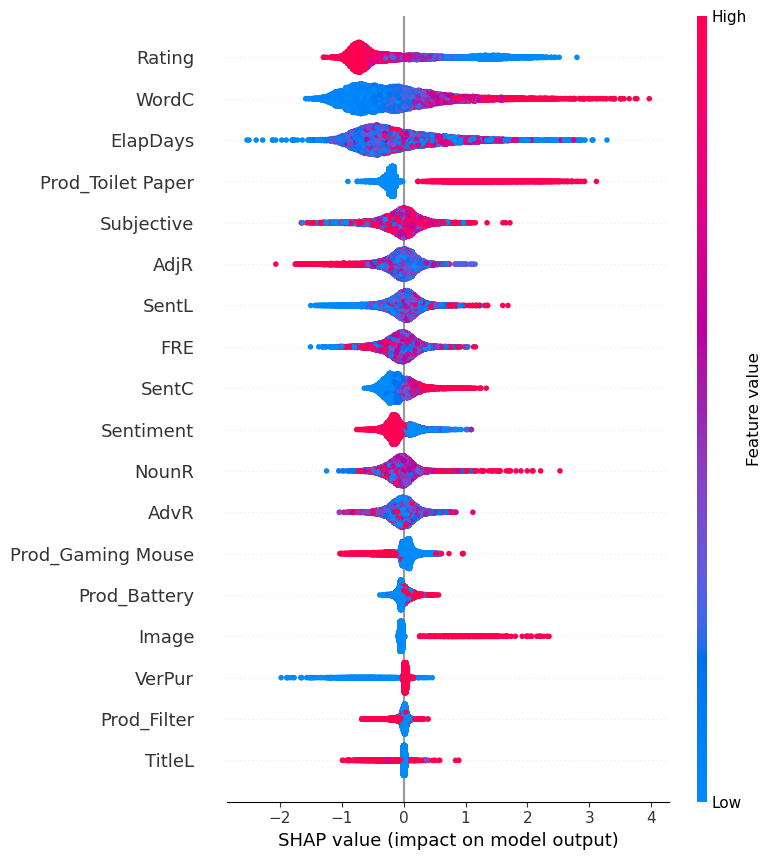

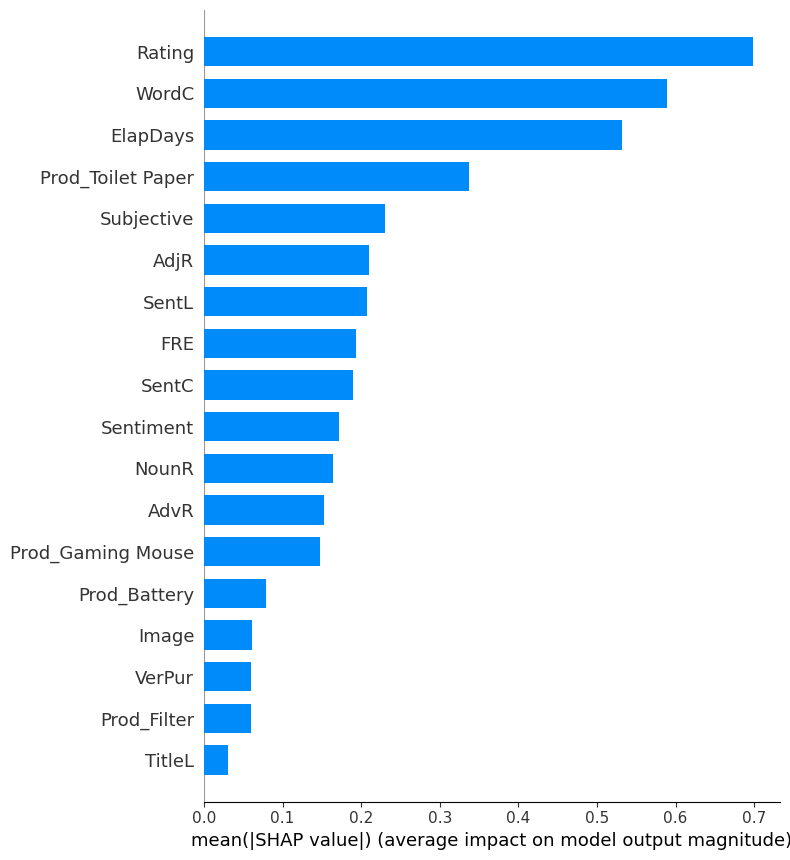

In [12]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.show()

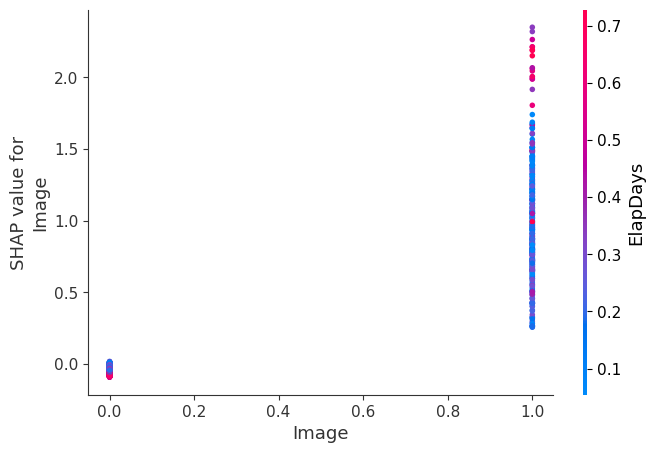

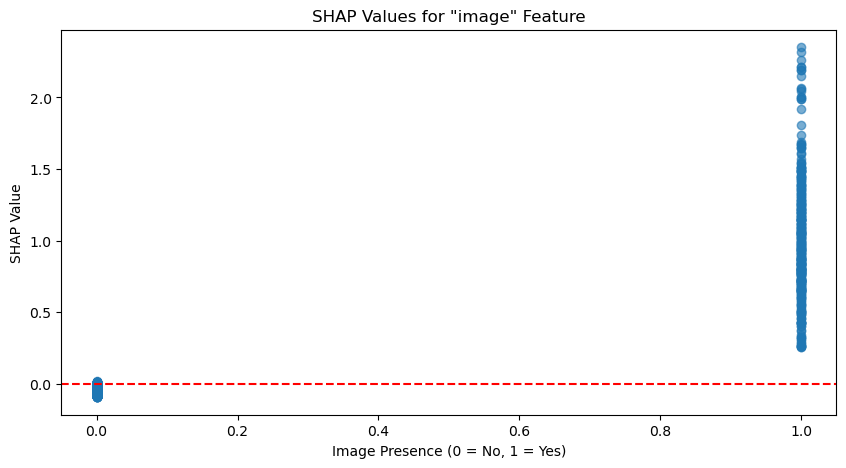

In [13]:
# Plot specifically for the 'image' feature
shap.dependence_plot('Image', shap_values, X_train)

# Extract SHAP values for the 'image' feature
image_shap_values = shap_values[:, X_train.columns.get_loc('Image')]

# Plot SHAP values for 'image'
plt.figure(figsize=(10, 5))
plt.scatter(X_train['Image'], image_shap_values, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('SHAP Values for "image" Feature')
plt.xlabel('Image Presence (0 = No, 1 = Yes)')
plt.ylabel('SHAP Value')
plt.show()


In [14]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)


In [15]:
# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

             features  average_shap_value
4              Rating            0.697995
7               WordC            0.588873
11           ElapDays            0.531507
3   Prod_Toilet Paper            0.337380
6          Subjective            0.230536
15               AdjR            0.209917
9               SentL            0.207093
17                FRE            0.193736
8               SentC            0.189894
5           Sentiment            0.172327
14              NounR            0.164180
16               AdvR            0.152353
2   Prod_Gaming Mouse            0.147951
0        Prod_Battery            0.078694
12              Image            0.061131
13             VerPur            0.059638
1         Prod_Filter            0.059224
10             TitleL            0.030568


# 2. Applying SMOTE for Imbalanced Dataset

In [16]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())



Class distribution after SMOTE:
0.0    11522
1.0     8000
Name: count, dtype: int64


In [17]:
# Train model with SMOTE balanced data
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_default = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Default Model Evaluation:
Accuracy: 0.8404371584699454
F1 Score: 0.4725433526011561
AUC: 0.6807057014983184
Confusion Matrix:
[[3518  323]
 [ 407  327]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      3841
         1.0       0.50      0.45      0.47       734

    accuracy                           0.84      4575
   macro avg       0.70      0.68      0.69      4575
weighted avg       0.83      0.84      0.84      4575

Mean Cross-Validated Accuracy: 0.7993641899834177


In [18]:
# With considering inbalanced data
from collections import Counter
sqrt = np.sqrt

# Assuming y_train is your ndarray
counts = Counter(y_train.flatten())

# counts[0] will give you the count of 0s
# counts[1] will give you the count of 1s
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight
weight_ratio = sqrt(count_of_zeros /count_of_ones)

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)

Class distribution in the training set: Counter({0.0: 11522, 1.0: 2204})
scale_pos_weight: 2.28643121372584


# 3. Hyperparameter tuning

In [19]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [20]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                 
0.7720218579234973                                     
SCORE:                                                                            
0.7746448087431694                                                                
  1%|          | 1/100 [00:00<00:15,  6.22trial/s, best loss: -0.7720218579234973]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.7713661202185792                                                                
  3%|▎         | 3/100 [00:00<00:10,  9.20trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.7711475409836066                                                                
SCORE:                                                                            
0.7674316939890711                                                                
  4%|▍         | 4/100 [00:00<00:11,  8.13trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.7691803278688525                                                                
SCORE:                                                                            
0.7720218579234973                                                                
  6%|▌         | 6/100 [00:00<00:12,  7.60trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.7724590163934426                                                                
SCORE:                                                                            
0.7678688524590164                                                                
SCORE:                                                                            
0.7672131147540984                                                                
 10%|█         | 10/100 [00:01<00:10,  8.60trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7691803278688525                                                                 
SCORE:                                                                             
0.7707103825136612                                                                 
SCORE:                                                                             
0.7674316939890711                                                                 
 13%|█▎        | 13/100 [00:01<00:09,  8.98trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7739890710382513                                                                 
SCORE:                                                                             
0.7676502732240437                                                                 
 15%|█▌        | 15/100 [00:01<00:08, 10.02trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7746448087431694                                                                 
SCORE:                                                                             
0.772896174863388                                                                  
SCORE:                                                                             
0.7678688524590164                                                                 
 17%|█▋        | 17/100 [00:02<00:08,  9.36trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7687431693989071                                                                 
SCORE:                                                                             
0.7746448087431694                                                                 
 19%|█▉        | 19/100 [00:02<00:08, 10.11trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7672131147540984                                                                 
SCORE:                                                                             
0.7691803278688525                                                                 
SCORE:                                                                             
0.7678688524590164                                                                 
 23%|██▎       | 23/100 [00:02<00:07, 10.45trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7680874316939891                                                                 
SCORE:                                                                             
0.7689617486338798                                                                 
SCORE:                                                                             
0.766775956284153                                                                  
 25%|██▌       | 25/100 [00:02<00:07,  9.68trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7691803278688525                                                                 
SCORE:                                                                             
0.7696174863387978                                                                 
 27%|██▋       | 27/100 [00:02<00:07, 10.37trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7687431693989071                                                                 
SCORE:                                                                             
0.766775956284153                                                                  
SCORE:                                                                             
0.7676502732240437                                                                 
 31%|███       | 31/100 [00:03<00:06, 10.36trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7691803278688525                                                                 
SCORE:                                                                             
0.7687431693989071                                                                 
SCORE:                                                                             
0.7678688524590164                                                                 
 33%|███▎      | 33/100 [00:03<00:06,  9.76trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7672131147540984                                                                 
SCORE:                                                                             
0.7672131147540984                                                                 
 35%|███▌      | 35/100 [00:03<00:06, 10.43trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7720218579234973                                                                 
SCORE:                                                                             
0.7698360655737705                                                                 
SCORE:                                                                             
0.7676502732240437                                                                 
 39%|███▉      | 39/100 [00:04<00:05, 10.37trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7698360655737705                                                                 
SCORE:                                                                             
0.7693989071038252                                                                 
SCORE:                                                                             
0.7687431693989071                                                                 
 41%|████      | 41/100 [00:04<00:06,  9.66trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.766775956284153                                                                  
SCORE:                                                                             
0.7746448087431694                                                                 
SCORE:                                                                             
0.7691803278688525                                                                 
 45%|████▌     | 45/100 [00:04<00:05,  9.76trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.766775956284153                                                                  
SCORE:                                                                             
0.7713661202185792                                                                 
 47%|████▋     | 47/100 [00:04<00:05, 10.33trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7683060109289618                                                                 
SCORE:                                                                             
0.7678688524590164                                                                 
SCORE:                                                                             
0.7711475409836066                                                                 
 49%|████▉     | 49/100 [00:05<00:05,  9.69trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7687431693989071                                                                 
SCORE:                                                                             
0.7689617486338798                                                                 
SCORE:                                                                             
0.7707103825136612                                                                 
 53%|█████▎    | 53/100 [00:05<00:04,  9.63trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7746448087431694                                                                 
SCORE:                                                                             
0.7687431693989071                                                                 
 55%|█████▌    | 55/100 [00:05<00:04, 10.23trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7691803278688525                                                                 
SCORE:                                                                             
0.7665573770491804                                                                 
SCORE:                                                                             
0.7672131147540984                                                                 
 57%|█████▋    | 57/100 [00:06<00:04,  9.61trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7676502732240437                                                                 
SCORE:                                                                             
0.7737704918032787                                                                 
SCORE:                                                                             
0.7689617486338798                                                                 
 61%|██████    | 61/100 [00:06<00:03,  9.90trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7720218579234973                                                                 
SCORE:                                                                             
0.7715846994535519                                                                 
SCORE:                                                                             
0.7722404371584699                                                                 
 63%|██████▎   | 63/100 [00:06<00:03,  9.30trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7744262295081967                                                                 
SCORE:                                                                             
0.7746448087431694                                                                 
SCORE:                                                                             
0.7746448087431694                                                                 
 67%|██████▋   | 67/100 [00:07<00:03,  9.20trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7689617486338798                                                                 
SCORE:                                                                             
0.7685245901639344                                                                 
SCORE:                                                                             
0.7691803278688525                                                                 
 69%|██████▉   | 69/100 [00:07<00:03,  8.93trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7689617486338798                                                                 
 71%|███████   | 71/100 [00:07<00:03,  9.64trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7676502732240437                                                                 
SCORE:                                                                             
0.7691803278688525                                                                 
SCORE:                                                                             
0.7733333333333333                                                                 
 74%|███████▍  | 74/100 [00:07<00:02,  9.60trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7676502732240437                                                                 
SCORE:                                                                             
0.7746448087431694                                                                 
 75%|███████▌  | 75/100 [00:08<00:02,  8.79trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7678688524590164                                                                 
SCORE:                                                                             
0.7669945355191257                                                                 
 78%|███████▊  | 78/100 [00:08<00:02,  8.60trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7711475409836066                                                                 
SCORE:                                                                             
0.7672131147540984                                                                 
 80%|████████  | 80/100 [00:08<00:02,  9.46trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7700546448087432                                                                 
SCORE:                                                                             
0.7678688524590164                                                                 
SCORE:                                                                             
0.7683060109289618                                                                 
 83%|████████▎ | 83/100 [00:08<00:01,  9.00trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7746448087431694                                                                 
SCORE:                                                                             
0.7659016393442623                                                                 
 84%|████████▍ | 84/100 [00:09<00:01,  8.18trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7672131147540984                                                                 
SCORE:                                                                             
0.7687431693989071                                                                 
 87%|████████▋ | 87/100 [00:09<00:01,  7.50trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7691803278688525                                                                 
SCORE:                                                                             
0.7669945355191257                                                                 
 88%|████████▊ | 88/100 [00:09<00:01,  7.12trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7704918032786885                                                                 
 90%|█████████ | 90/100 [00:09<00:01,  8.01trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7687431693989071                                                                 
SCORE:                                                                             
0.7689617486338798                                                                 
SCORE:                                                                             
0.7678688524590164                                                                 
 93%|█████████▎| 93/100 [00:10<00:00,  8.18trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7746448087431694                                                                 
 94%|█████████▍| 94/100 [00:10<00:00,  7.72trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7685245901639344                                                                 
SCORE:                                                                             
0.7733333333333333                                                                 
 96%|█████████▌| 96/100 [00:10<00:00,  8.50trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7720218579234973                                                                 
SCORE:                                                                             
0.766775956284153                                                                  
SCORE:                                                                             
0.766775956284153                                                                  
 99%|█████████▉| 99/100 [00:10<00:00,  8.66trial/s, best loss: -0.7746448087431694]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.7672131147540984                                                                 
100%|██████████| 100/100 [00:10<00:00,  9.09trial/s, best loss: -0.7746448087431694]
The best hyperparameters are :  

{'colsample_bytree': 0.8901156437223077, 'gamma': 6.21937524282968, 'max_depth': 15.0, 'min_child_weight': 1.0, 'reg_alpha': 164.0, 'reg_lambda': 0.7075991896703888}


`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



In [21]:
best_hyperparams={'colsample_bytree': 0.6912196339708366, 'gamma': 7.933913866056239, 'max_depth': 12, 'min_child_weight': 6.0, 'reg_alpha': 47.0, 'reg_lambda': 0.9319510603930535}




In [22]:
# Train model with default hyperparameters
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_hyp.fit(X_train, y_train)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Default Model Evaluation:
Accuracy: 0.8404371584699454
F1 Score: 0.4725433526011561
AUC: 0.6807057014983184
Confusion Matrix:
[[3518  323]
 [ 407  327]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91      3841
         1.0       0.50      0.45      0.47       734

    accuracy                           0.84      4575
   macro avg       0.70      0.68      0.69      4575
weighted avg       0.83      0.84      0.84      4575

Mean Cross-Validated Accuracy: 0.826827775323471


[18:44:34] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


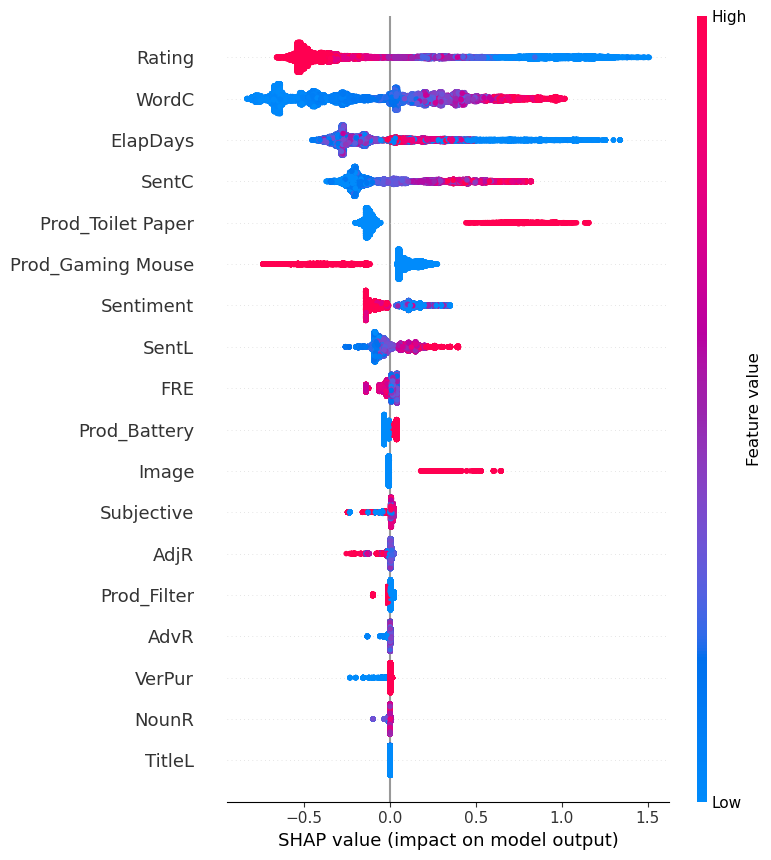

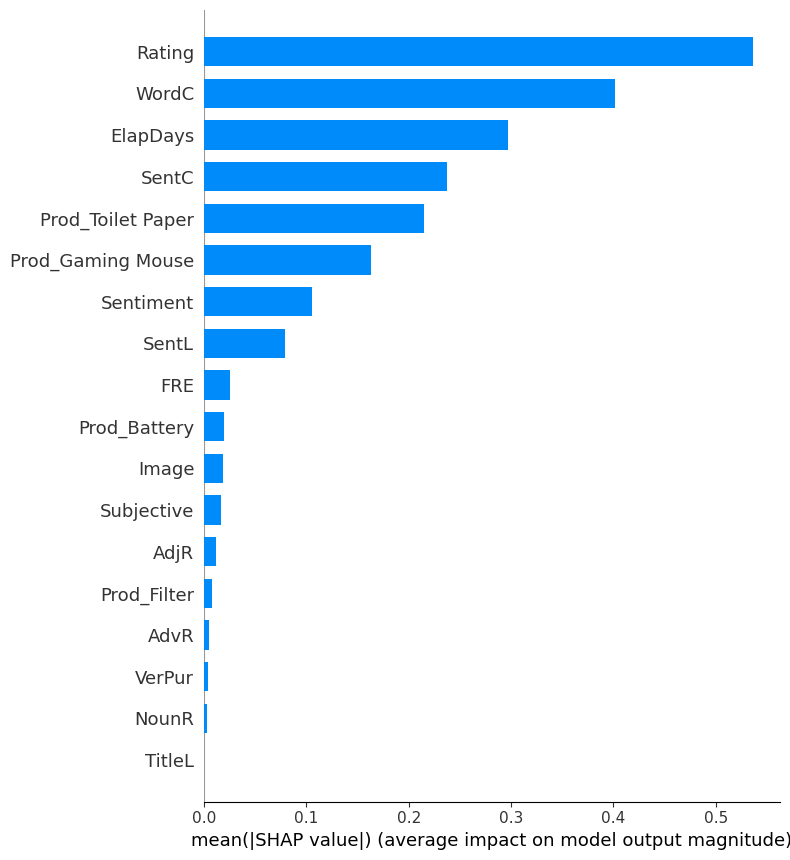

In [23]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_balanced)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=False)
plt.show()


[18:44:36] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


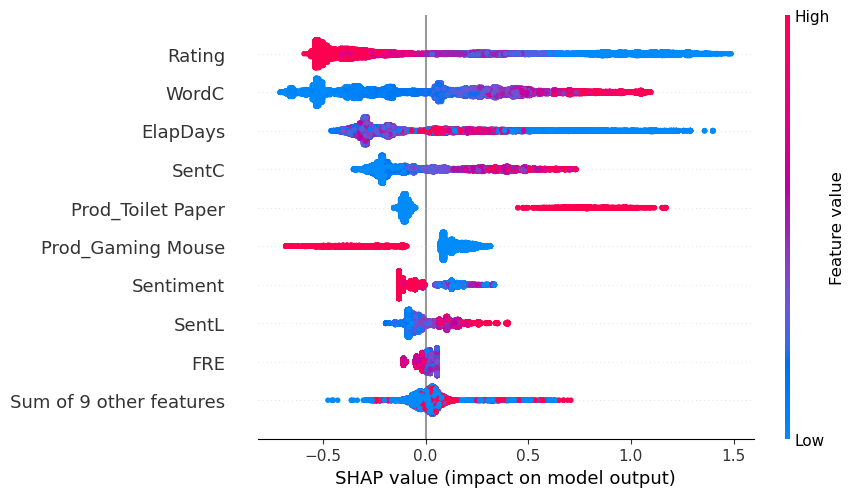

In [24]:
# compute SHAP values
explainer = shap.Explainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.beeswarm(shap_values, max_display=10)


[18:44:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


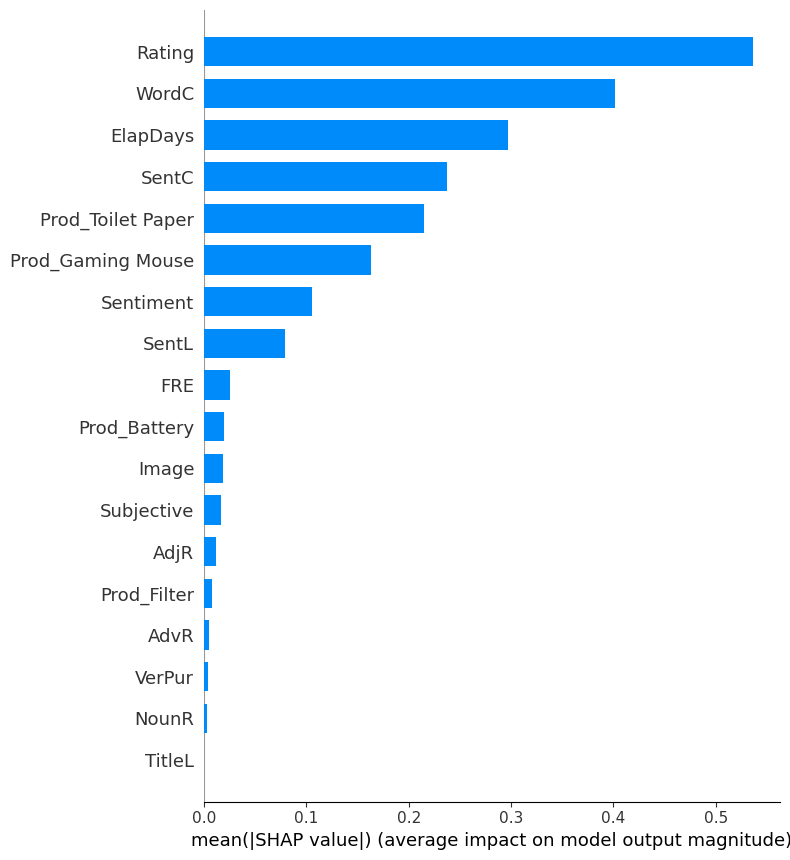

In [25]:
import matplotlib.pyplot as plt
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot with beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=True)


[18:44:41] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


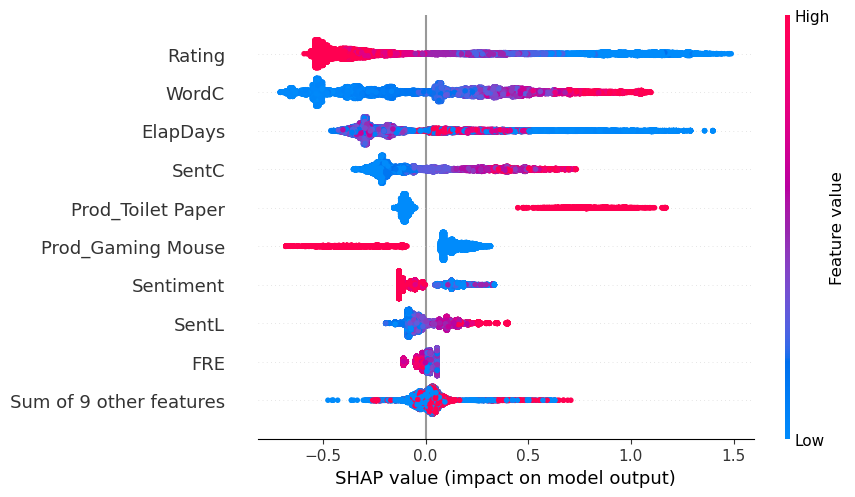

In [26]:
# compute SHAP values
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.beeswarm(shap_values, max_display=10)